## Imports

In [95]:
import pickle
from multiprocessing import Pool

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, MaxNLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import gridspec

import GPy as gpy
import emcee

# matplotlib style sheet
plt.style.use('../../neutron_stars_tf/etf/style_1.mplstyle')

# Seed
np.random.seed(100)

## Setup

In [96]:
# Text box properties
text_bbox = dict(boxstyle='round',
                 facecolor=(1, 1, 1, 1),
                 edgecolor='k',
                 pad=0.5)

# Colours
colours = [plt.cm.tab10(i) for i in range(10)]

# Load data

In [114]:
columnHeadings = ['col1',
                  'N_Z', 'N', 'Z', 'A', 'El',
                  'origin',
                  'mass_excess', 'mass_excess_unc',
                  'BE_A', 'BE_A_unc',
                  'B', 'beta_decay', 'beta_decay_unc',
                  'atomic_mass_1', 'atomic_mass_2', # digits pre- and post- decimal point are in separate columns
                  'atomic_mass_unc']

# Width of each column in AME data file
AMEwidths = [1, 3, 5, 5, 5, 4, 4, 14, 11, 11, 9, 3, 11, 9, 4, 13, 11]

exp = pd.read_fwf('mass16.txt', widths=AMEwidths,
                 names=columnHeadings, skiprows=39)

# Clean data and add new $Cu$ isotopes

In [115]:
# Mass excess of neutron and proton
neutronME = float(exp.loc[0, 'mass_excess'])
protonME = float(exp.loc[1, 'mass_excess'])

# Keep only nuclide and binding energy info
exp = exp[['N', 'Z', 'A', 'El', 'BE_A', 'BE_A_unc']]

"""
Add new mass measurements of neutron-rich copper isotopes from PRL 119, 192592 (2017)
"""
isotopes = (exp.El.eq('Cu')) & (exp.A.between(75, 79))
# New mass excesses for Cu-75 to Cu-79 (keV), and their uncertainties
newMassEx = np.array([-54470.01, -50981.55, -48862.8, -44772., -42408.])
newMassExUnc = [0.76, 0.89, 1.2, 17., 105.]
# Convert to binding energy per particle
newBE_A = (exp[isotopes].N*neutronME + 29*protonME - newMassEx) / exp[isotopes].A
newBE_A_unc = newMassExUnc / exp[isotopes].A
# Add new values to data frame
exp[isotopes] = exp[isotopes].assign(BE_A=newBE_A)
exp[isotopes] = exp[isotopes].assign(BE_A_unc=newBE_A_unc)

# Mass values that are not purely experimental have a '#'
exp['estimated'] = exp['BE_A'].str.contains('#')
# New Cu isotopes should have 'False' for 'estimated' column
exp[isotopes] = exp[isotopes].assign(estimated=False)

# Remove '#' and convert BE_A and BE_A unc. to floats
exp[['BE_A', 'BE_A_unc']] = exp[['BE_A', 'BE_A_unc']].replace('#', '', regex=True)
exp = exp.astype({'BE_A': 'float64', 'BE_A_unc': 'float64'})

# Convert to MeV
exp.loc[:,['BE_A', 'BE_A_unc']] /= 1000.

# Total BE and experimental errors
exp['BE'] = exp.BE_A * exp.A
exp['BE_unc'] = exp.BE_A_unc * exp.A

# Load DZ residuals

In [118]:
# DZ mass table with errors
DZwidths = [12, 12, 21, 31]
DZmasses = pd.read_fwf('DZ_mass_table_noerror.dat', widths=DZwidths,
                    names=['Z', 'N', 'BE_DZ', 'BE_DZ_unc'], skiprows=1)

# Merge experimental and DZ data, re-order columns, sort by Z then N, complete A columnb
df = DZmasses.merge(exp, how='outer', on=['Z', 'N'])
df = df.reindex(columns=['Z', 'N', 'A', 'El',
                               'BE', 'BE_unc', 'BE_A', 'BE_A_unc', 'estimated',
                               'BE_DZ', 'BE_DZ_unc'])
df = df.sort_values(by=['Z', 'N'])
df.A = df.Z + df.N

# List of all Z values
ZList = df.Z.unique()
# Make element list from (row 0, column 3) of all entries where El is not NaN, for specified Z
ElList = [df[(df.El.notna()) & (df.Z == Z)].iloc[0,3] for Z in ZList]
ElDict = dict(zip(ZList, ElList))
# Use dictionary to fill in blank values for El
df.El = df.Z.map(ElDict)

# Calculate residuals
df['residual'] = df.BE_DZ - df.BE

# Train GP on DZ residuals

## Prepare training and testing data

In [119]:
# Select all or subset of residuals for training GP
Zmin, Zmax = 0, 120
trainQuery = f'Z >= {Zmin} & Z <= {Zmax} & BE_DZ.notna()'

train = df.query(trainQuery)
train = train[train.estimated.eq(False)]
train.to_pickle('GP_training/train.pkl')

# Average error of experimental BEs
trainErrorsMean = train.BE_unc.mean()
print(f'Mean experimental error: {trainErrorsMean}')

Xtrain = train[['N', 'Z']].to_numpy()
Ytrain = np.atleast_2d(train.residual.to_numpy()).T

Mean experimental error: 0.028379744662681467


In [120]:
# Select estimated values (in training range) for testing
test = df.query(trainQuery)
test = test[test.estimated.eq(True)]
test.to_pickle('GP_training/test.pkl')

Xtest = train[['N', 'Z']].to_numpy()
Ytest = np.atleast_2d(train.residual.to_numpy()).T

## Model setup

In [121]:
# Create 2D RBF kernel, with ARD
kernel = gpy.kern.RBF(input_dim=2, ARD=True)

# Create GPy model
model = gpy.models.GPRegression(Xtrain, Ytrain, kernel=kernel, noise_var=trainErrorsMean**2)
# # Fix GP noise parameter to average scale of experimental uncertainty
# model.Gaussian_noise.variance.fix()
print(f'Initial model parameters: {model.param_array}')

# Optimise with restarts to ensure maximum likelihood is found
model.optimize_restarts(num_restarts=4, messages=True, clear_after_finish=True)

# Save model and print some info
with open('GP_training/model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

print(f'RBF variance after MLE optimisation: {model.rbf.param_array[0]}')
print(f'RBF lengthscales after MLE optimisation: {model.rbf.param_array[1:]}')
print(f'Nugget sigma: {np.sqrt(model.param_array[3])}')

Initial model parameters: [1.00000000e+00 1.00000000e+00 1.00000000e+00 8.05409907e-04]


Optimization restart 1/4, f = 328.5615890869153


Optimization restart 2/4, f = 328.56158909851365


Optimization restart 3/4, f = 328.5615890900608


Optimization restart 4/4, f = 328.5615890875083
RBF variance after MLE optimisation: 0.4331896215296758
RBF lengthscales after MLE optimisation: [2.65560664 1.97160615]
Nugget sigma: 0.20044676735582662


# Predictions with DZ+GP

## Selected chains

In [122]:
def predictResiduals(model, XPred):
    # GP predictions at unknown points
    meanNew, covNew = model.predict_noiseless(XPred)

    # Save to file
    np.savetxt('GP_training/GP_predictions.dat',
               np.hstack((XPred, meanNew, covNew)),
               fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
               header='\tN\tZ\tmeans\t\t\t\tcovs')
    
    return meanNew, covNew

with open('GP_training/model.pkl', 'rb') as f:
    model = pickle.load(f)

# Range of Z for predictions
pred_Zmin, pred_Zmax = 0, 120
pred = df.query(f'Z >= {pred_Zmin} & Z <= {pred_Zmax} & BE_DZ.notna()')
pred = pred[pred.estimated.notna()]
XPred = pred[['N', 'Z']].to_numpy()

# Predict
means, covs = predictResiduals(model, XPred)

# Mean and sigma for GP model of DZ10 residuals
pred['GP_mean'] = means
pred['GP_sigma'] = np.sqrt(covs)

# Residuals of new combined DZ10-GP model
pred['res_DZGP'] = pred.residual - pred.GP_mean

# New DZ10-GP mass table
pred['BE_DZGP'] = pred.BE_DZ - pred.GP_mean
# Uncertainty for new model is DZ10 uncertainty and GP sigma added in quadrature
pred['BE_DZGP_unc'] = np.sqrt(pred.BE_DZ_unc**2 + pred.GP_sigma**2)

# Save to files
pred.to_pickle('GP_training/predict.pkl')
np.savetxt('GP_training/DZ10-GP_massTable.dat',
           pred[['Z', 'N', 'A', 'BE_DZGP', 'BE_DZGP_unc']].values,
           fmt='%5d%4d%4d\t%.9e\t%.9e',
           header='\tZ\tN\tA\tBE [MeV]\t\tsigma [MeV]')

pred

,Z,N,A,El,BE,BE_unc,BE_A,BE_A_unc,estimated,BE_DZ,BE_DZ_unc,residual,GP_mean,GP_sigma,res_DZGP,BE_DZGP,BE_DZGP_unc
0,8,6,14,O,98.731892,0.000028,7.052278,0.000002,False,97.985313,0.099748,-0.746579,-0.862367,0.157950,0.115788,98.847680,0.186809
2,8,7,15,O,111.955380,0.000495,7.463692,0.000033,False,111.788696,0.094771,-0.166684,-0.118413,0.116728,-0.048272,111.907108,0.150356
4,8,8,16,O,127.619296,0.000000,7.976206,0.000000,False,127.980778,0.109583,0.361482,0.677124,0.111195,-0.315642,127.303654,0.156118
9,8,9,17,O,131.762376,0.000000,7.750728,0.000000,False,132.852696,0.085803,1.090320,1.147246,0.108847,-0.056926,131.705450,0.138599
15,8,10,18,O,139.807746,0.000000,7.767097,0.000000,False,141.108399,0.089204,1.300653,1.114841,0.107989,0.185812,139.993558,0.140068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,110,167,277,Ds,2004.649000,0.277000,7.237000,0.001000,True,2009.060868,0.263640,4.411868,0.054255,0.657597,4.357613,2009.006613,0.708478
5127,110,168,278,Ds,2011.330000,0.556000,7.235000,0.002000,True,2016.169905,0.270302,4.839905,0.018572,0.658097,4.821333,2016.151333,0.711445
5162,110,169,279,Ds,2016.612000,0.558000,7.228000,0.002000,True,2023.028579,0.273589,6.416579,0.005524,0.658164,6.411055,2023.023055,0.712763
5197,110,170,280,Ds,2023.280000,0.840000,7.226000,0.003000,True,2029.868770,0.277791,6.588770,0.001428,0.658171,6.587342,2029.867342,0.714393


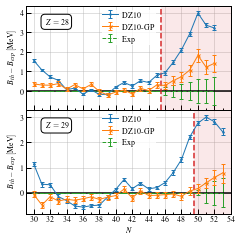

In [153]:
# Text labels for plots
labels = ['DZ10', 'DZ10-GP']

# Plot
Zvals = [28, 29]
vertLinePos = [45.5, 49.5]

fig, axs = plt.subplots(len(Zvals), 1, figsize=(3.4, 3.4), sharex=True, gridspec_kw={'hspace': 0.})

for i, (ax, Z, v) in enumerate(zip(axs, Zvals, vertLinePos)):
    chain = pred.query('Z == @Z & N >= 30')
    
    # Mark x-axis
    ax.axhline(0., c='k')
    
    # Mark and shade extrapolation region
    ax.axvline(v, ls='--', c=colours[3])
    ax.axvspan(v, 54., color=colours[3], alpha=0.1, lw=0)
    
    ax.errorbar(chain.N, chain.residual, yerr=chain.BE_DZ_unc,
                capsize=2., c=colours[0], fmt='.-', lw=1.,
                label=labels[0], zorder=3)
    ax.errorbar(chain.N, chain.res_DZGP, yerr=chain.BE_DZGP_unc,
                capsize=2., c=colours[1], fmt='x-', lw=1.,
                label=labels[1], zorder=4)
    ax.errorbar(chain.N, np.zeros(len(chain.N)), yerr=chain.BE_unc,
                capsize=2., c=colours[2], fmt='--', lw=1.,
                label='Exp', zorder=2)
    
    ax.text(0.15, 0.85, fr'$Z={Z}$',
            bbox=text_bbox,
            ha='center', va='center',
            transform=ax.transAxes)
    
    ax.set_ylabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')
    ax.set_xlim([29., 54.])
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    ax.legend(loc='upper center')

axs[-1].set_xlabel('$N$')
fig.align_ylabels(axs[:])

fig.tight_layout()
fig.savefig('GP_training/Z_chains.pdf')

## Residuals (measured nuclei only) as function of $A$

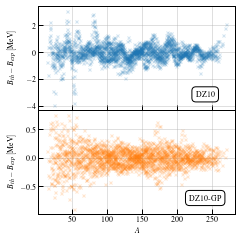

In [158]:
fig, axs = plt.subplots(2, 1, figsize=(3.4, 3.4), sharex=True, gridspec_kw={'hspace': 0.})

axs[0].plot(pred[pred.estimated == False].A, pred[pred.estimated == False].residual,
            c=colours[0], ls='', marker='x', alpha=0.2)
axs[1].plot(pred[pred.estimated == False].A, pred[pred.estimated == False].res_DZGP,
            c=colours[1], ls='', marker='x', alpha=0.2)

axs[1].set_xlabel(r'$A$')

for ax, l in zip(axs, labels):
    ax.set_ylabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')
    ax.text(0.85, 0.15, l,
            ha='center', va='center',
            bbox=text_bbox,
            transform=ax.transAxes)

fig.align_ylabels(axs[:])

fig.tight_layout()
fig.savefig('GP_training/residuals_vs_A.pdf')

## Comparing residual distributions (for measured nuclei only)

sigma for DZ for training data: 0.601 MeV
sigma for DZ-GP for training data: 0.178 MeV


,Z,N,A,BE,BE_unc,BE_A,BE_A_unc,BE_DZ,BE_DZ_unc,residual,GP_mean,GP_sigma,res_DZGP,BE_DZGP,BE_DZGP_unc
count,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000
mean,56.687020,79.473100,136.160120,1095.782383,0.028380,8.161090,0.000356,1095.775147,0.085082,-0.007236,-0.007000,0.091513,-0.000236,1095.782147,0.126013
std,24.504396,37.964415,62.087373,462.250270,0.092071,0.378730,0.001540,462.248257,0.024480,0.601359,0.559334,0.014411,0.177792,462.250850,0.023263
min,8.000000,6.000000,14.000000,97.330832,0.000000,6.083177,0.000000,95.578376,0.053369,-3.976998,-3.277054,0.084709,-0.906396,96.793074,0.101578
25%,38.000000,49.250000,87.000000,750.142402,0.001719,7.878538,0.000015,750.021194,0.066715,-0.352999,-0.318462,0.084833,-0.104635,749.997193,0.109273
50%,57.000000,80.000000,137.000000,1136.306996,0.006435,8.218080,0.000048,1135.761404,0.078714,-0.023549,-0.015985,0.085384,0.001629,1136.137311,0.119459
75%,78.000000,108.000000,186.000000,1470.804276,0.017817,8.466059,0.000122,1470.712118,0.096316,0.330304,0.310522,0.089437,0.105227,1470.665383,0.135483
max,110.000000,160.000000,270.000000,1958.519250,1.336650,8.794553,0.023008,1960.599225,0.260682,3.074272,2.595016,0.181089,0.758902,1958.673257,0.300088


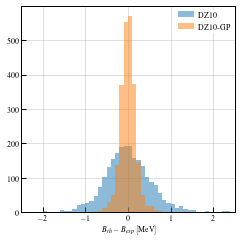

In [159]:
print(f'sigma for DZ for training data: {pred[pred.estimated == False].residual.std():.3f} MeV')
print(f'sigma for DZ-GP for training data: {pred[pred.estimated == False].res_DZGP.std():.3f} MeV')

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

ax.hist(train.residual, bins=np.linspace(-5., 5., 101),
        label=labels[0],
        alpha=0.5)
ax.hist(pred[pred.estimated == False].res_DZGP, bins=np.linspace(-5., 5., 101),
        label=labels[1],
        alpha=0.5)

ax.set_xlabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')
ax.set_xlim([-2.5, 2.5])

ax.legend()

fig.tight_layout()
fig.savefig('GP_training/residualDists.pdf')

pred[pred.estimated == False].describe()

# MCMC inference

## Walker start positions

In [164]:
# Load model
with open('GP_training/model.pkl', 'rb') as f:
    model = pickle.load(f)

# Fix GP noise parameter to average scale of experimental uncertainty
model.Gaussian_noise.variance.fix()

# MCMC Options
nwalkers = 40
nchain = 2000

# RBF variance and lengthscales from ML optimisation
x0 = model.rbf.param_array

# Number of parameters
ndim = x0.shape[0]

print(f'Dimensions = {ndim}')
print(f'Walkers = {nwalkers}')
print(f'Chain length = {nchain}')
print(f'Function calls = {nwalkers*nchain}')

# Initialise walkers in 'small Gaussian ball' around minimum
p0 = x0 + 1e-5 * np.random.randn(nwalkers, ndim)

Dimensions = 3
Walkers = 40
Chain length = 2000
Function calls = 80000


## Sample

In [163]:
# Log-probability function
def log_prob(p, model):
    if any(p <= 0.):
        return -np.inf
        
    else:
        model[''] = list(p) + [model.param_array[3]]
        return model.log_likelihood()

# Enable (shared-memory) parallelisation
with Pool() as pool:
    # Create sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(model,), pool=pool)
    
    # Run sampler with progress bar
    sampler.run_mcmc(p0, nchain, progress=True)

# Autocorrelation time
tau = sampler.get_autocorr_time()

# Number of samples to discard from beginning of chain
burnin = int(2 * np.max(tau))

# How much to thin chain
thin = int(0.5 * np.min(tau))

print(f'tau = {tau}')
print(f'Burn-in = {burnin}')
print(f'Thin = {thin}')

# 3D array of samples
samples = sampler.get_chain()

# Save all samples for reuse
np.save('samples', samples)

# Remove 'burn-in' samples, and thin samples so not too many correlated samples are plotted
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

# Save modified samples for plotting again
np.savetxt('flat_samples.dat', flat_samples)

# Extract log probabilites of chain
log_prob_samples = sampler.get_log_prob(discard=burnin, thin=thin, flat=True)

# Save log-probs for plotting
np.savetxt('log_probs.dat', log_prob_samples)

  0%|          | 1/2000 [05:27<181:59:38, 327.75s/it]Process ForkPoolWorker-11:
Process ForkPoolWorker-9:



KeyboardInterrupt: 